In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
import Source.Util.preprocessing as prep
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obs_names = np.array(["p_{T,l1}", "\phi_{l1}", "\eta_{l1}", "\mu_{l1}",
                    "p_{T,l2}", "\phi_{l2}", "\eta_{l2}", "\mu_{l2}",
                  "p_{T,j1}", "\phi_{j1}", "\eta_{j1}", "\mu_{j1}",
                  "p_{T,j2}", "\phi_{j2}", "\eta_{j2}", "\mu_{j2}"])

In [3]:
runpath = "runs/ART_local_4253/"
#runpath = "runs/set5_discr2_prep1/"
#runpath = "runs/set1_13dim_bin050_prep0_discr2/"
#runpath = "runs/set1_13dim_bin050_prep0_discr1/"
#runpath = "runs/set3_4dim_semiautoreg/"
#runpath = "runs/set3_13dim_semiautoreg_max/"

# Load data

In [4]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
params["device"]=get_device()

In [5]:
data_raw = np.load("../data/Z_2.npy")
data_raw = prep.preformat(data_raw, params)
channels = params["channels"]
n_gauss = params["n_gauss"]
data, data_mean, data_std, data_u, data_s = prep.preprocess(data_raw, params=params)

# Initialize modified model class

In [6]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)

Build model AutoRegGMM with n_head=1, n_per_head=8, n_blocks=2, intermediate_fac=2, n_gauss=10


<All keys matched successfully>

In [7]:
data_split = params["data_split"]
n_data = len(data)
cut1 = int(n_data - data_split[0])
model.train_loader = DataLoader(dataset=data[:cut1], batch_size=params["batch_size"], shuffle=True)

# Generate samples

In [8]:
n_samples = 10
samples, xs, probs, probsindiv = model.sample_n_bonus(n_samples)
samples = samples[:,1:]

print(samples)
print(np.shape(probs), np.shape(xs), np.shape(probsindiv), np.shape(samples), np.shape(data))

/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


[[ 0.4900508  -0.118234    0.49344653 -0.38720486  0.38993746  1.0570016
  -0.7362228  -1.6232859  -1.5372509  -1.3778781   0.68183887  1.4635062
   0.30500373]
 [-0.65496475 -0.4910516   0.28008944 -0.62434995  1.8277882  -0.7864026
  -1.0115246   1.3493137   0.3236321  -1.7021757  -0.23278043 -1.123631
   0.67846155]
 [-0.964545   -1.077268    1.6400086   1.0663277   0.40344763  0.46356833
   1.4479439  -0.06993505 -0.07388714  0.10677332  0.56259906 -1.8334982
   1.1004391 ]
 [ 0.13808614  0.02564137  0.39396963  0.46917686  0.6590638   0.15264931
  -0.34881863  0.10155818  0.16535671  0.55820596 -0.16511339  0.13294263
  -0.7804279 ]
 [ 0.45731658 -1.2836105  -1.3094792   0.3700785   1.2376156  -0.28813624
   0.4301344  -1.8384848   0.87844825  0.4513294   0.3064781  -1.1795349
  -0.54919773]
 [ 0.12412509 -1.0110297  -1.8784784  -0.10237636  0.27742344  0.31040674
  -0.23045695 -0.67252815  0.6151273  -1.0802476   0.36166573 -0.47237504
   1.6535815 ]
 [-0.04518151 -0.5955237   1.

# Test plot

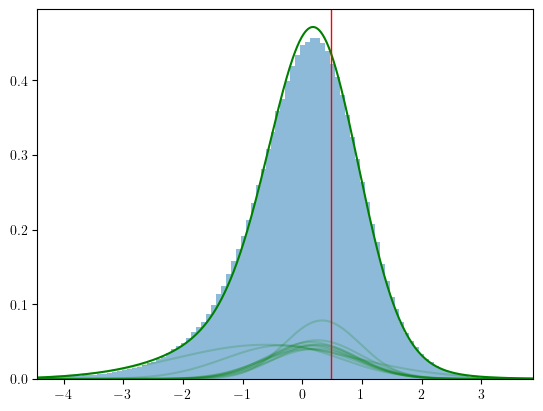

In [9]:
idim=0
isample=0
bins=100
xmin=np.min(xs[idim,:])
xmax=np.max(xs[idim,:])
plt.hist(data[:,idim], alpha=.5, bins=bins, range=(xmin, xmax), density=True, align="mid", rwidth=1.)
plt.plot(xs[idim,:], probs[isample, idim, :], color="g")
for igauss in range(n_gauss):
    plt.plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", linestyle="-", alpha=.2)
_, ymax = plt.ylim()
plt.vlines(samples[isample,idim], 0., ymax, "r", linewidth=1)
plt.xlim(xmin, xmax)
plt.ylim(0., ymax)
plt.show()

TBD
- Plot also the individual gaussians (nicer)

# Fancy plot

In [10]:
def probPlot(probs, samples, filenameOut=None, var=None, maxSamples=None, nbins=100):
    nsamples = np.shape(samples)[0]
    if(maxSamples!=None):
       nsamples = np.min([nsamples, maxSamples])
    ndim = np.shape(samples)[1]
    f, axarr = plt.subplots(nsamples, ndim, figsize=(3*ndim,3*nsamples), sharex=True,
                           gridspec_kw={"hspace": 0.})
    plt.tight_layout()
    
    ymax=np.zeros(ndim)
    for isample in range(nsamples):
        print(f"Working on sample {isample}/{nsamples}")
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            
            axarr[isample,idim].plot(xs[idim,:], probs[isample,idim,:], color="g")
            axarr[isample,idim].hist(data[:,idim], density=True, alpha=.5, range=(xmin, xmax), rwidth=1., bins=nbins, align="mid")
            for igauss in range(n_gauss):
                axarr[isample,idim].plot(xs[idim,:], probsindiv[isample,idim,igauss,:], color="g", alpha=.2)
            _, ymax0 = axarr[isample,idim].get_ylim()

            ymax[idim] = np.max([ymax[idim], ymax0])
            print(samples[isample,idim], ymax[idim], xmin, xmax)
            axarr[isample,idim].vlines(samples[isample,idim], 0., ymax[idim], color="r")
            if((type(var) is np.ndarray) and isample==nsamples-1):
                axarr[isample,idim].set_xlabel(r"${%s}$ bin" %var[idim])
    for isample in range(nsamples):
        for idim in range(ndim):
            xmin=xs[idim,0]
            xmax=xs[idim,-1]
            axarr[isample,idim].set_ylim(0, ymax[idim])
            #axarr[isample,idim].set_xlim(xmin, xmax)
    if(filenameOut!=None):
        f.savefig(filenameOut, format="pdf")
    #plt.close()

In [ ]:
probPlot(probs, samples, var=obs_names[params["channels"]], maxSamples=5, 
         filenameOut="Scripts/visualizeAutoreg/visualizeAutoreg_4dim_5gauss.pdf")

Working on sample 0/5
0.4900508 0.4947218433022499 -4.437716484069824 3.8750665187835693
-0.118234 0.41913301795721053 -3.262286901473999 3.506521224975586
0.49344653 0.5707267516813693 -3.323279619216919 3.0857796669006348
-0.38720486 0.5473363060161616 -4.255023002624512 4.989521503448486
0.38993746 0.4198781535029411 -3.169504404067993 3.097771644592285
